In [61]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

# Helper Function to plot Decision Boundary

In [63]:
# for the approach, see https://scikit-learn.org/stable/auto_examples/ensemble/plot_voting_decision_regions.html

from itertools import product

def plot_decision_boundary(X_arr, clf_arr, clf_name_arr, rows=3, cols=3, xgboost=False):
    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, x_max]x[y_min, y_max].
    x_min, x_max = X_arr[i].iloc[:, 0].min(), X_arr[i].iloc[:, 0].max()  # this is always 0,1 if MinMaxSclaer is used
    y_min, y_max = X_arr[i].iloc[:, 1].min(), X_arr[i].iloc[:, 1].max() # this is always 0,1 if MinMaxSclaer is used
    steps = 300  # --> looks better if larger
    xx, yy = np.meshgrid(np.arange(x_min, x_max, (x_max-x_min)/steps),
                         np.arange(y_min, y_max, (y_max-y_min)/steps))  


    f, axarr = plt.subplots(rows, cols, sharex='col', sharey='row', figsize=(20, 18))

    # for each model, create the decision boundary and plot it into the right sub-plot (via idx)
    for idx, clf, tt in zip(product(list(range(rows)), list(range(cols))), clf_arr, clf_name_arr):
        if xgboost:
            Z = clf.predict(np.c_[xx.ravel(), yy.ravel()], validate_features=False).reshape(xx.shape)  # predict the mesh
        else:
            Z = clf.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)  # predict the mesh

        axarr[idx[0], idx[1]].contourf(xx, yy, Z, alpha=0.4)  # draw decision boundary
        axarr[idx[0], idx[1]].scatter(X.iloc[:, 0], X.iloc[:, 1], c=y, s=20, edgecolor='k')  # plot the original data (normalized)
        axarr[idx[0], idx[1]].set_title(tt)

    plt.show()

# Unstable Learners: Example Data with Decision Trees

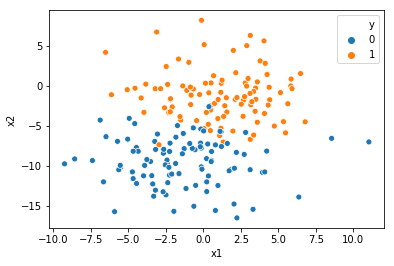

In [64]:
from sklearn.datasets import make_classification, make_blobs
data = make_blobs(200, 2, centers=2, random_state=2, cluster_std=3)
df = pd.DataFrame(data[0], columns=['x1', 'x2'])
df['y'] = data[1]
sns.scatterplot(x=df.x1, y=df.x2, hue=df.y); plt.show()

In [65]:
n_samples = 9
sample_size = 0.7
samples = [df.sample(n=int(len(df)*sample_size), replace=False, random_state=i*1000) for i in range(n_samples)]

In [66]:
max_tree_depth = 10

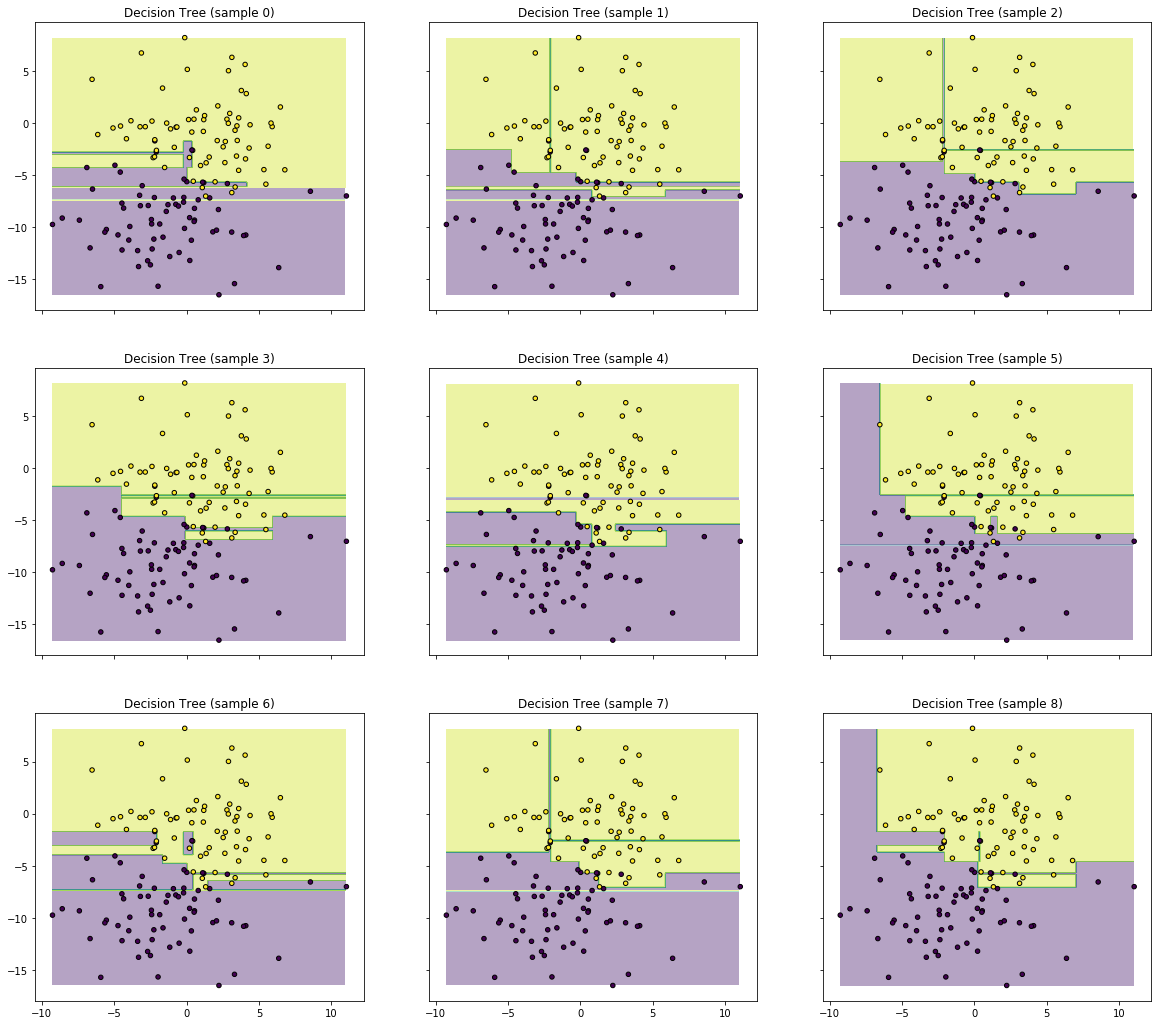

In [71]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

clf_arr = []  # this array holds the predictors
clf_name_arr = []  # this array holds the names of the predictors for visualization
X_arr = []

for i in range(n_samples):
    X = samples[i].iloc[:, [0,1]] 
    X_arr.append(X)
    y = samples[i]['y']
    clf = DecisionTreeClassifier(max_depth=max_tree_depth)
    #clf = KNeighborsClassifier(n_neighbors=10)
    clf.fit(X, y)
    clf_arr.append(clf)
    clf_name_arr.append("Decision Tree (sample {})".format(i))
    #clf_name_arr.append("kNN (sample {})".format(i))
    
plot_decision_boundary(X_arr, clf_arr, clf_name_arr)

# Combining Decision Trees with Bagging

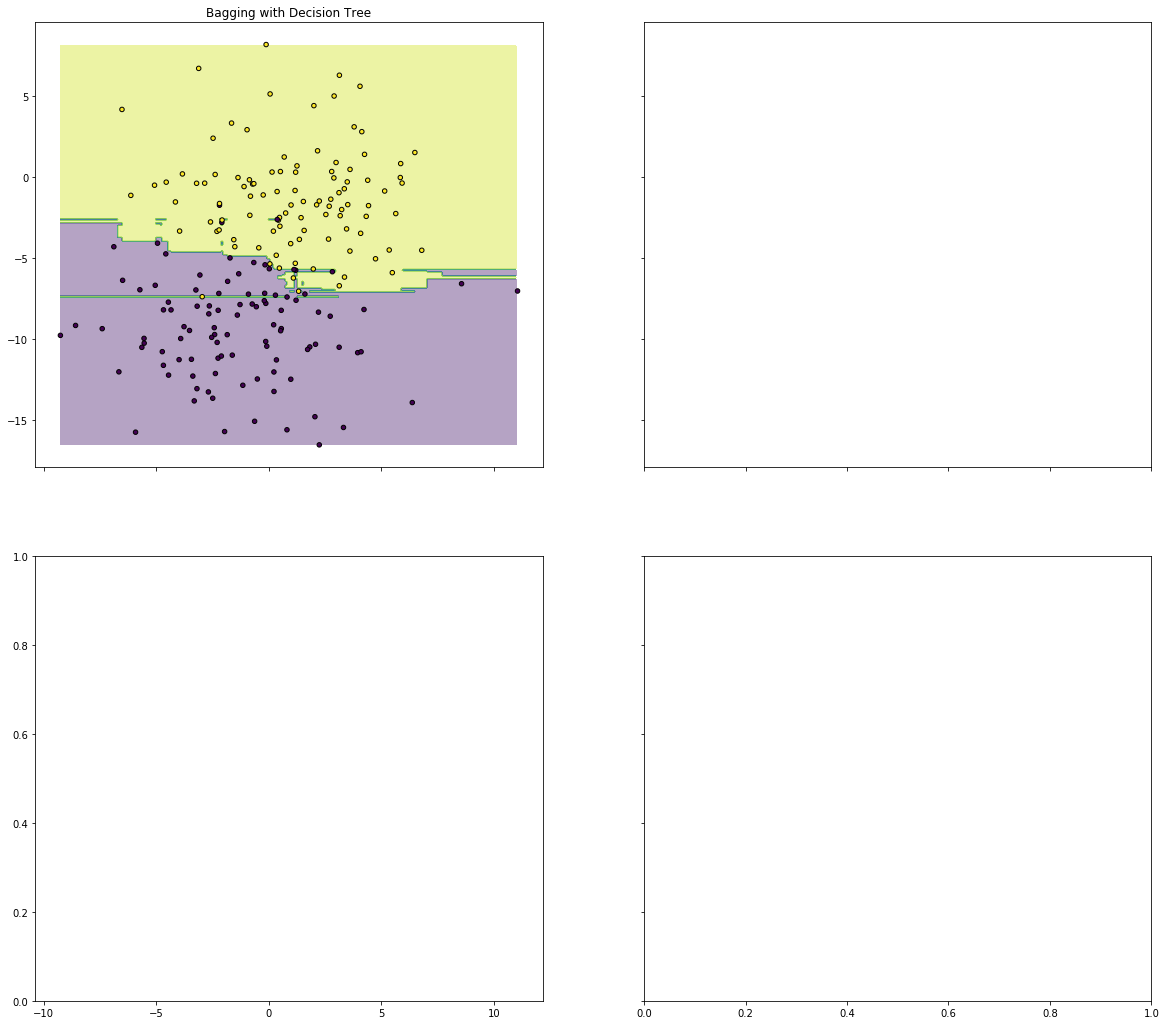

In [73]:
from sklearn.ensemble import BaggingClassifier

n_estimators = 30 # use this number of decision trees

clf_arr = []  # this array holds the predictors
clf_name_arr = []  # this array holds the names of the predictors for visualization
X_arr = []

for i in range(1):
    X = df.iloc[:, [0,1]]
    X_arr.append(X)    
    y = df['y']
    base_clf = DecisionTreeClassifier(max_depth=max_tree_depth)
    clf = BaggingClassifier(base_clf, n_estimators=n_estimators, random_state=1000)
    clf.fit(X, y)
    clf_arr.append(clf)
    clf_name_arr.append("Bagging with Decision Tree")
    
plot_decision_boundary(X_arr, clf_arr, clf_name_arr, rows=2, cols=2)

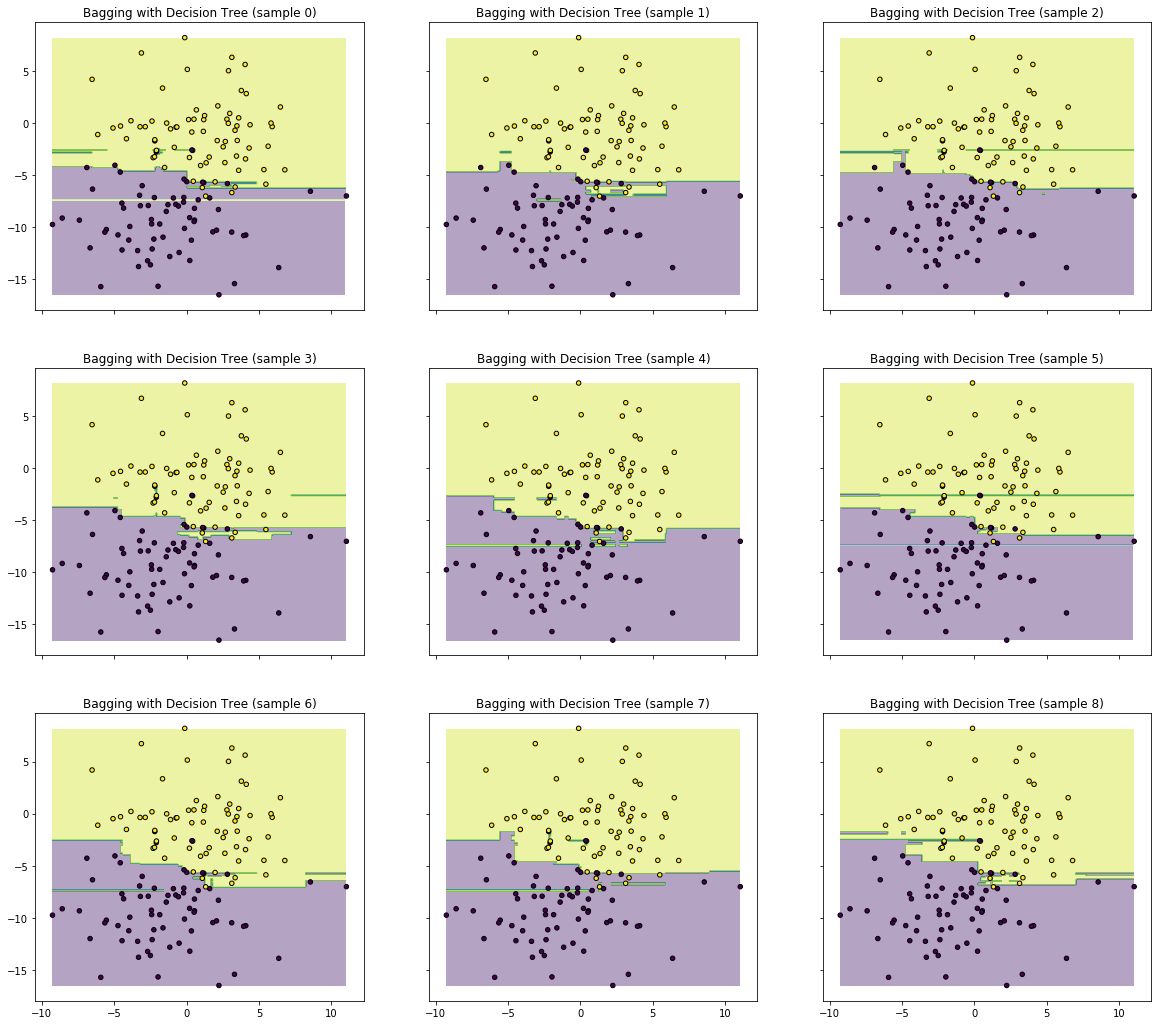

In [74]:
clf_arr = []  # this array holds the predictors
clf_name_arr = []  # this array holds the names of the predictors for visualization
X_arr = []

for i in range(n_samples):
    X = samples[i].iloc[:, [0,1]]
    X_arr.append(X)
    y = samples[i]['y']
    base_clf = DecisionTreeClassifier(max_depth=max_tree_depth)
    clf = BaggingClassifier(base_clf, n_estimators=n_estimators, random_state=1000)
    clf.fit(X, y)
    clf_arr.append(clf)
    clf_name_arr.append("Bagging with Decision Tree (sample {})".format(i))
    
plot_decision_boundary(X_arr, clf_arr, clf_name_arr)

# Load mpg dataset and prepare for classification

In [75]:
df = sns.load_dataset('mpg')
df = df.dropna()
df.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin,name
0,18.0,8,307.0,130.0,3504,12.0,70,usa,chevrolet chevelle malibu
1,15.0,8,350.0,165.0,3693,11.5,70,usa,buick skylark 320
2,18.0,8,318.0,150.0,3436,11.0,70,usa,plymouth satellite
3,16.0,8,304.0,150.0,3433,12.0,70,usa,amc rebel sst
4,17.0,8,302.0,140.0,3449,10.5,70,usa,ford torino


In [76]:
df['origin_numbered'] = df.origin.map({'europe' : 1, 'japan' : 1, 'usa':0})
df['origin_simple'] = df.origin.map({'europe' : 'non-usa', 'japan' : 'non-usa', 'usa':'usa'})

In [77]:
def plot_cnf_matrix(cnf_matrix):
    class_names=[0, 1] # name  of classes
    fig, ax = plt.subplots(figsize=(4,2.5))
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names)
    plt.yticks(tick_marks, class_names)
    # create heatmap
    sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, annot_kws={"size":16}, cmap="YlGnBu" ,fmt='g')
    ax.xaxis.set_label_position("top")
    plt.tight_layout()
    plt.title('Confusion matrix', y=1.1)
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    plt.show()

# Visualization of the Decision Boundary of Decision Tree with Bagging

## Train model with bagging and decision trees on the mpg dataset

In [78]:
X = df[['mpg', 'weight']]
y = df.origin_numbered
base_clf = DecisionTreeClassifier(max_depth=10)
clf = BaggingClassifier(base_clf, n_estimators=n_estimators, random_state=1)
clf = clf.fit(X, y)

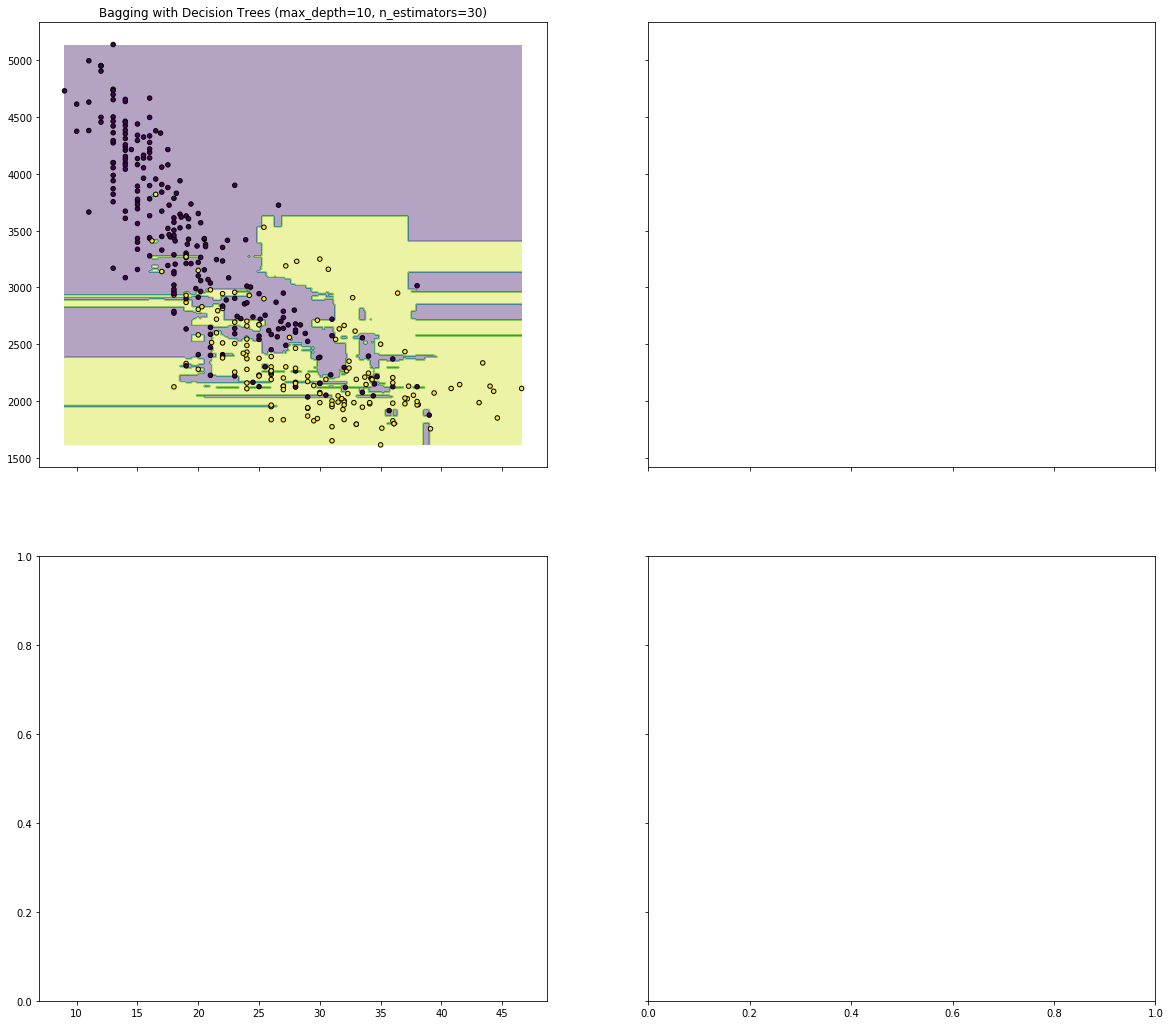

In [79]:
X_arr = []
X_arr.append(X)
clf_arr = []  # this array holds the knn-predictors
clf_name_arr = []  # this array holds the names of the knn-predictors for visualization
for i in range(1):
    base_clf = DecisionTreeClassifier(max_depth=10)
    clf = BaggingClassifier(base_clf, n_estimators=30, random_state=1)    
    clf.fit(X, y)
    clf_arr.append(clf)
    clf_name_arr.append("Bagging with Decision Trees (max_depth=10, n_estimators=30)")

plot_decision_boundary(X_arr, clf_arr, clf_name_arr, rows=2, cols=2)

### Calculation of some metrics

In [80]:
from sklearn import metrics
from sklearn.metrics import confusion_matrix

def print_metrics(y, prediction, threshold=0.5):
    accuracy = metrics.accuracy_score(y, prediction)
    precision = metrics.precision_score(y, prediction)
    recall = metrics.recall_score(y, prediction)
    cnf_matrix = metrics.confusion_matrix(y, prediction)
    fpr = cnf_matrix[0, 1] / (cnf_matrix[0, 0] + cnf_matrix[0, 1])
    print("Threshold: {:.2f}  | Accuracy : {:.2f} - Precision: {:.2f} - Recall(=TPR) : {:.2f} - FPR : {:.2f}".format(threshold, accuracy, precision, recall, fpr))


### We can adjust the threshold at which a car is classified as non-usa (default was 0.5)
E.g. if it is really important to classify a car as a non-usa car, we would lower the threshold. <br>
A more realistic example: it might be highly important to classify someone as ill if there is the slightest chance, since the benefit is much larger compared to the struggles when being classified false-positive.

Threshold: 0.01  | Accuracy : 0.71 - Precision: 0.56 - Recall(=TPR) : 1.00 - FPR : 0.47


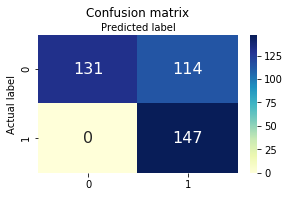

Threshold: 0.25  | Accuracy : 0.91 - Precision: 0.81 - Recall(=TPR) : 1.00 - FPR : 0.14


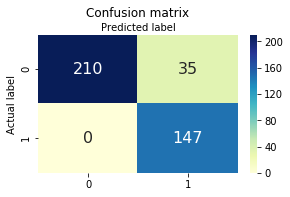

Threshold: 0.49  | Accuracy : 0.99 - Precision: 0.99 - Recall(=TPR) : 0.99 - FPR : 0.01


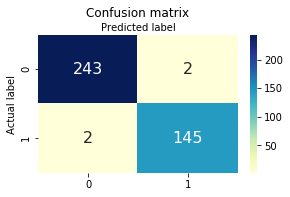

Threshold: 0.73  | Accuracy : 0.93 - Precision: 1.00 - Recall(=TPR) : 0.82 - FPR : 0.00


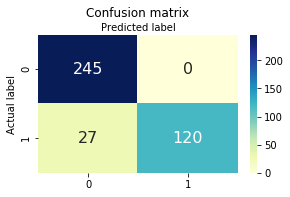

Threshold: 0.97  | Accuracy : 0.70 - Precision: 1.00 - Recall(=TPR) : 0.20 - FPR : 0.00


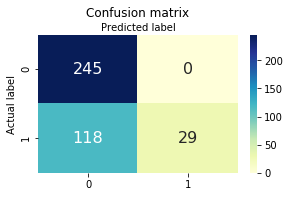

In [81]:
for i in range(1, 101, 24):
    thr = round(i / 100.0, 2)
    prediction = (clf.predict_proba(X) >= thr)[:, 1]
    print_metrics(y, prediction, thr)
    plot_cnf_matrix(confusion_matrix(y, prediction))

True positive rate = recall = sensitivity: "probability of detection"<br>
False positive rate = 1 - specificity: probability of false alarm.

# ROC analysis


In [84]:
from sklearn.metrics import roc_curve, roc_auc_score

def plot_roc(y, prediction_probas, label=''):
    fpr, tpr, thresholds = roc_curve(y, prediction_probas)  # the roc-curve values are calculated by sklearn
    # create plot
    plt.plot(fpr, tpr, label='ROC curve (class non-usa)')
    plt.plot([0, 1], [0, 1], 'k--', label='Random guess')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve ' + label)
    plt.xlim([-0.02, 1])
    plt.ylim([0, 1.02])
    plt.legend(loc="lower right")
    plt.show()

# A good classifier is characterized by a large "area under (ROC) curve" (AUC)
The curve should be in the upper left part of the diagram. The ROC visualizes, how "sure" our model is when distinguishing between classes. When it's close to random guess, it is not a good model!

## Comparison to the other classifiers with train-test-split
A train-test-split is mandatory! Let us use more data and more features.

In [85]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df[['mpg', 'weight', 'horsepower', 'acceleration', 'cylinders', 'displacement']], 
                                                    df.origin_numbered)

In [86]:
def find_optimal_threshold(y_test, y_probas):
    """ find the optimal threshold using Youden's J statistic """
    fpr, tpr, thresholds = roc_curve(y_test, y_probas)  # the roc-curve values are calculated by sklearn
    optimal_idx = np.argmax(tpr - fpr)
    optimal_threshold = thresholds[optimal_idx]
    return optimal_threshold

### Decision Tree with Bagging

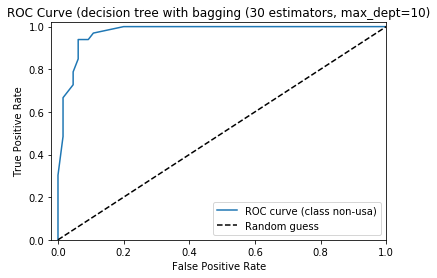

ROC_AUC: 0.9746
Optimal threshold: 0.5000
Accuracy: 0.9286


In [88]:
base_clf = DecisionTreeClassifier(max_depth=10)
clf = BaggingClassifier(base_clf, n_estimators=n_estimators, random_state=1)
clf.fit(X_train, y_train)

y_probas = clf.predict_proba(X_test) # predicted probabilities generated by sklearn classifier
plot_roc(y_test, y_probas[:,1], label="(decision tree with bagging (30 estimators, max_dept=10)")
print("ROC_AUC: {:.4f}".format(roc_auc_score(y_test, y_probas[:,1])))
print("Optimal threshold: {:.4f}".format(find_optimal_threshold(y_test, y_probas[:,1])))
print("Accuracy: {:.4f}".format(clf.score(X_test, y_test)))

### The other classifiers have been evaluated in the context of logistic regression

# Random Forest

In [89]:
from sklearn.ensemble import RandomForestClassifier

In [90]:
X = df[['mpg', 'weight']]
y = df.origin_numbered

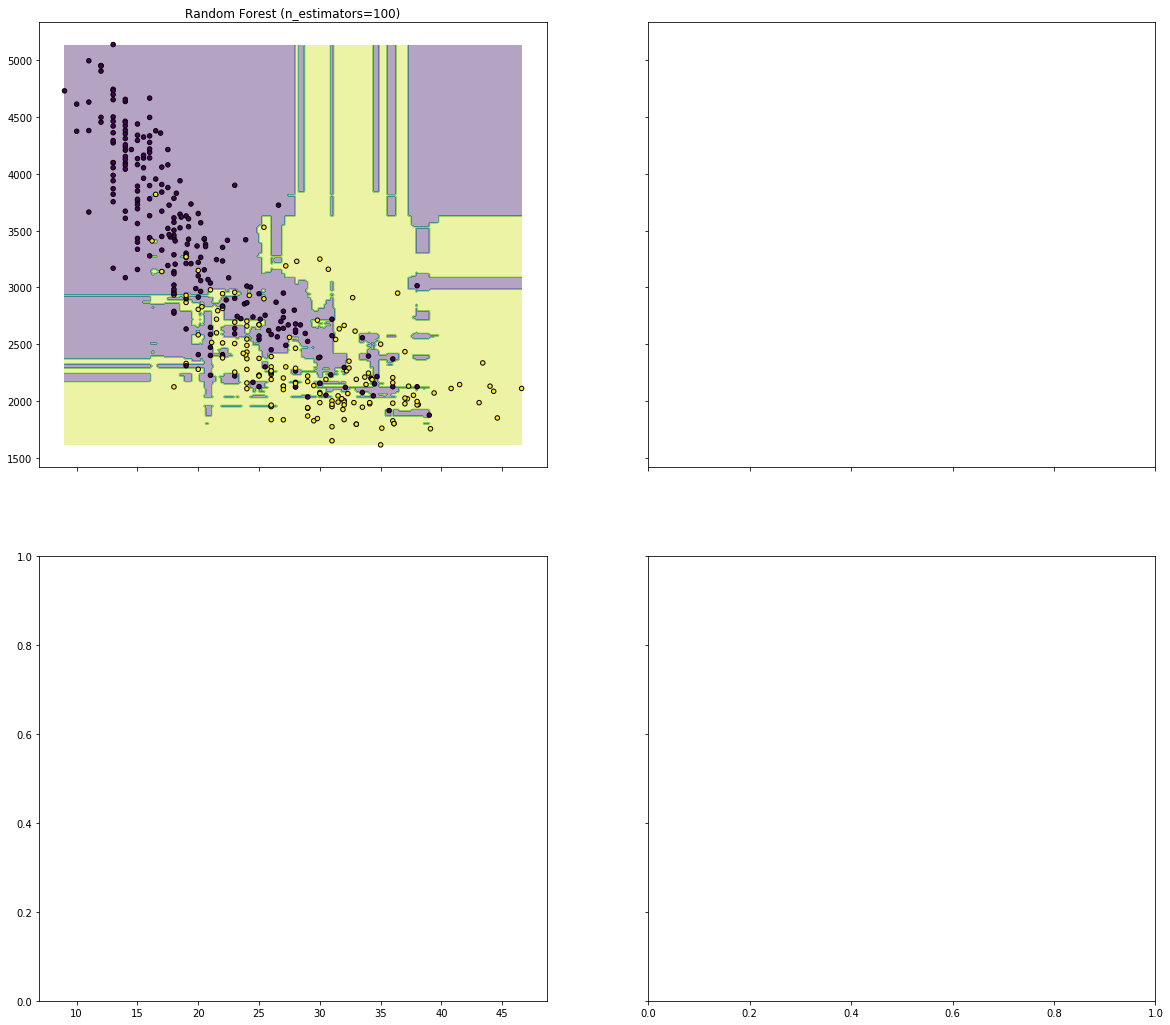

In [93]:
X_arr = []
X_arr.append(X)
clf_arr = []  # this array holds the knn-predictors
clf_name_arr = []  # this array holds the names of the knn-predictors for visualization
for i in range(1):
    clf = RandomForestClassifier(n_estimators=100, random_state=1)
    clf.fit(X, y)
    clf_arr.append(clf)
    clf_name_arr.append("Random Forest (n_estimators=100)")

plot_decision_boundary(X_arr, clf_arr, clf_name_arr, rows=2, cols=2)

## ROC analysis for Random Forest

In [94]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df[['mpg', 'weight', 'horsepower', 'acceleration', 'cylinders', 'displacement']], 
                                                    df.origin_numbered)

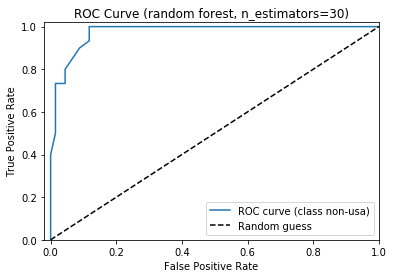

ROC_AUC: 0.9750
Optimal threshold: 0.3333
Accuracy: 0.9082


In [95]:
clf = RandomForestClassifier(n_estimators=30)
clf.fit(X_train, y_train)

y_probas = clf.predict_proba(X_test) # predicted probabilities generated by sklearn classifier
plot_roc(y_test, y_probas[:,1], label="(random forest, n_estimators=30)")
print("ROC_AUC: {:.4f}".format(roc_auc_score(y_test, y_probas[:,1])))
print("Optimal threshold: {:.4f}".format(find_optimal_threshold(y_test, y_probas[:,1])))
print("Accuracy: {:.4f}".format(clf.score(X_test, y_test)))

# Variance of RandomForest

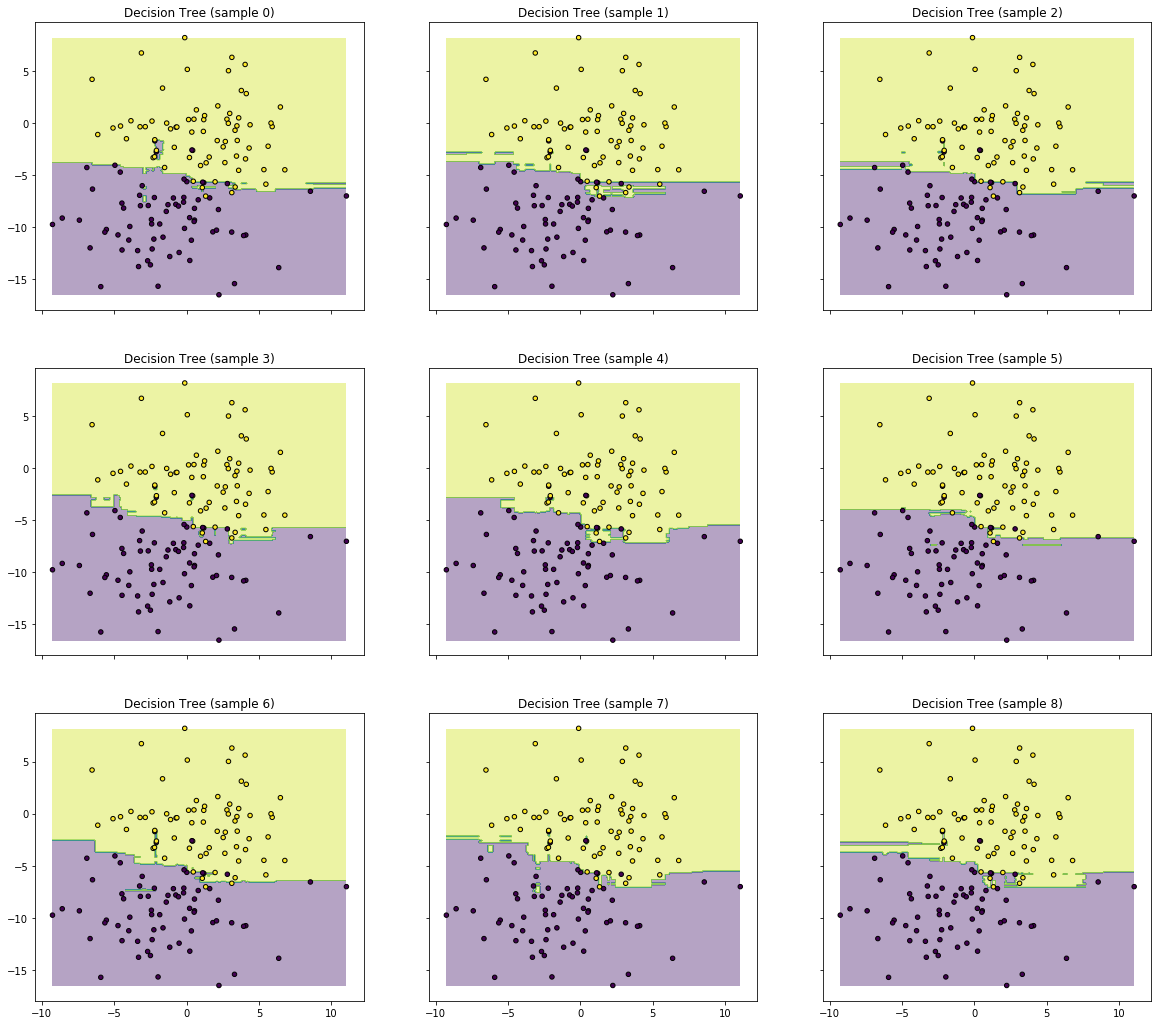

In [58]:
clf_arr = []  # this array holds the predictors
clf_name_arr = []  # this array holds the names of the predictors for visualization
X_arr = []

for i in range(n_samples):
    X = samples[i].iloc[:, [0,1]] 
    X_arr.append(X)
    y = samples[i]['y']
    clf = RandomForestClassifier(n_estimators=30, max_depth=max_tree_depth)
    clf.fit(X, y)
    clf_arr.append(clf)
    clf_name_arr.append("Decision Tree (sample {})".format(i))
        
plot_decision_boundary(X_arr, clf_arr, clf_name_arr)

# Decision Boundary of XGBoost

In [97]:
#import sys
#!{sys.executable} -m pip install xgboost
import xgboost as xgb

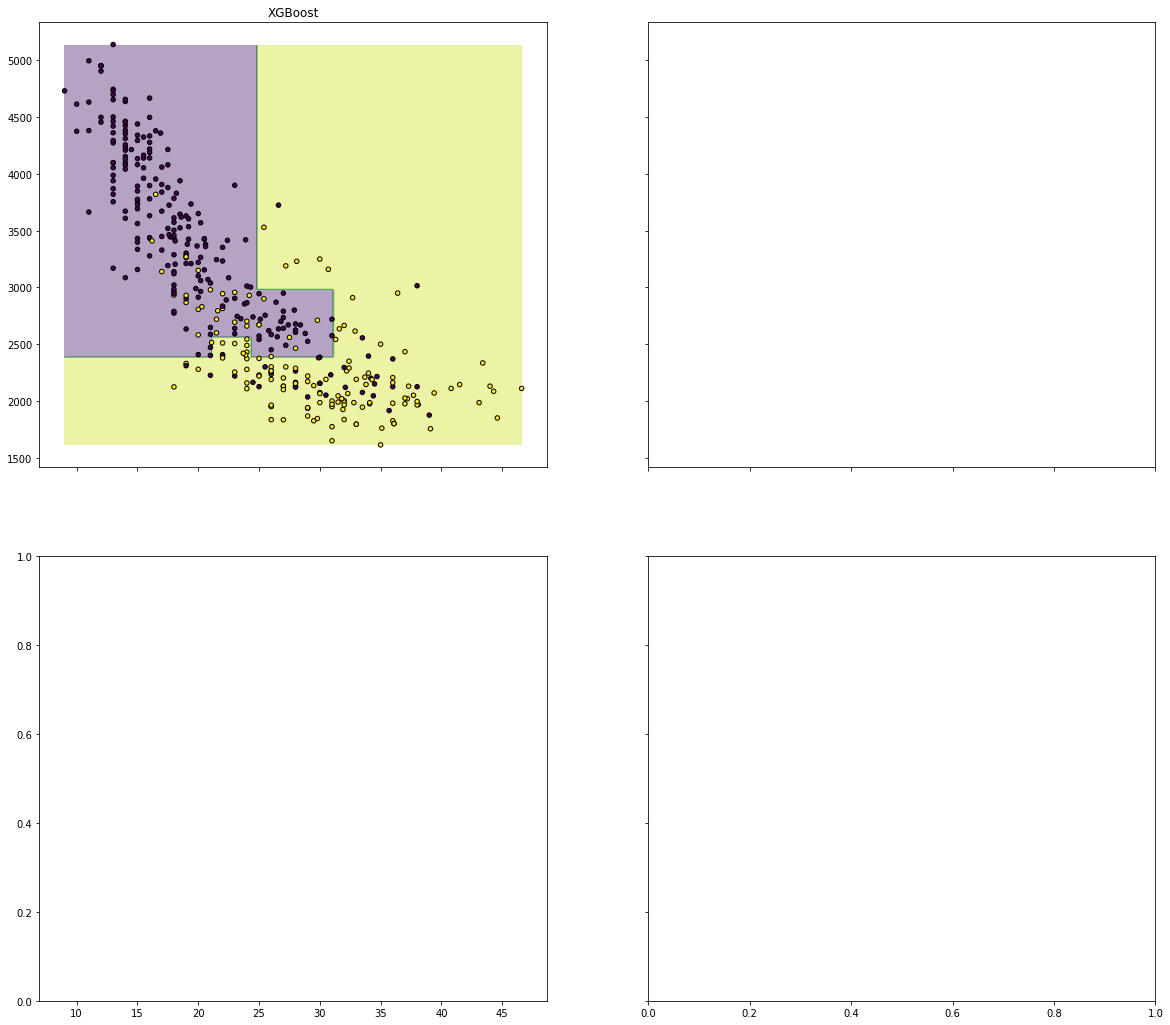

In [98]:
X = df[['mpg', 'weight']]
y = df.origin_numbered

clf = xgb.XGBClassifier(random_state=1,learning_rate=0.01)
clf.fit(X, y)

X_arr = []
X_arr.append(X)
clf_arr = []  # this array holds the knn-predictors
clf_name_arr = []  # this array holds the names of the knn-predictors for visualization

for i in range(1):
    clf = xgb.XGBClassifier(random_state=1,learning_rate=0.01)
    clf.fit(X, y)
    clf_arr.append(clf)
    clf_name_arr.append("XGBoost")

plot_decision_boundary(X_arr, clf_arr, clf_name_arr, rows=2, cols=2, xgboost=True)

# ROC analysis for XGBoost

In [36]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df[['mpg', 'weight', 'horsepower', 'acceleration', 'cylinders', 'displacement']], 
                                                    df.origin_numbered)

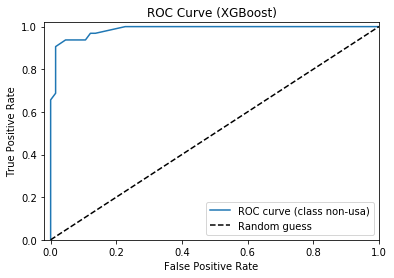

ROC_AUC: 0.9863
Optimal threshold: 0.5173
Accuracy: 0.9490


In [37]:
clf = xgb.XGBClassifier(random_state=1,learning_rate=0.01)
clf.fit(X_train, y_train)

y_probas = clf.predict_proba(X_test) # predicted probabilities generated by sklearn classifier
plot_roc(y_test, y_probas[:,1], label="(XGBoost)")
print("ROC_AUC: {:.4f}".format(roc_auc_score(y_test, y_probas[:,1])))
print("Optimal threshold: {:.4f}".format(find_optimal_threshold(y_test, y_probas[:,1])))
print("Accuracy: {:.4f}".format(clf.score(X_test, y_test)))

# Exemplary Model Tuning
## Random Forest

In [100]:
from sklearn.model_selection import GridSearchCV

X = df[['mpg', 'weight', 'horsepower', 'acceleration', 'cylinders', 'displacement', 'model_year']]  # note: added model_year
y = df.origin_numbered

param_grid = [
    {'max_depth': range(2, 21, 2),
    'n_estimators': range(10, 51, 10)}
]

clf = RandomForestClassifier(n_estimators=10)

search = GridSearchCV(clf, param_grid, cv=10)

search.fit(X, y)
print("Best parameter (CV score={:.2f}):{})".format(search.best_score_, search.best_params_))

Best parameter (CV score=0.90):{'max_depth': 18, 'n_estimators': 10})


C:\Users\peer.kueppers\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


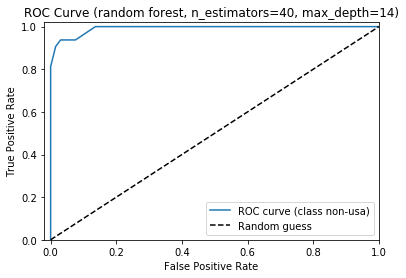

ROC_AUC: 0.9920
Optimal threshold: 0.6000
Accuracy: 0.9592


In [101]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
clf = RandomForestClassifier(max_depth=18, n_estimators=10, random_state=10)
clf.fit(X_train, y_train)

y_probas = clf.predict_proba(X_test) # predicted probabilities generated by sklearn classifier
plot_roc(y_test, y_probas[:,1], label="(random forest, n_estimators=40, max_depth=14)")
print("ROC_AUC: {:.4f}".format(roc_auc_score(y_test, y_probas[:,1])))
print("Optimal threshold: {:.4f}".format(find_optimal_threshold(y_test, y_probas[:,1])))
print("Accuracy: {:.4f}".format(clf.score(X_test, y_test)))

Threshold: 0.60  | Accuracy : 0.96 - Precision: 0.94 - Recall(=TPR) : 0.94 - FPR : 0.03


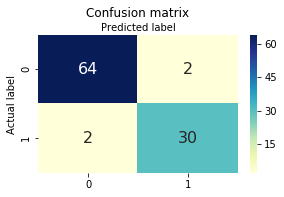

In [102]:
thr = 0.6
prediction = (clf.predict_proba(X_test) >= thr)[:, 1]
print_metrics(y_test, prediction, thr)
plot_cnf_matrix(confusion_matrix(y_test, prediction))

## XGBoost

In [103]:
param_grid = [
    {'max_depth': range(2, 21, 2),
    'n_estimators': range(10, 91, 20)}
]

clf = xgb.XGBClassifier()

search = GridSearchCV(clf, param_grid, cv=10)

search.fit(X, y)
print("Best parameter (CV score={:.2f}):{})".format(search.best_score_, search.best_params_))

Best parameter (CV score=0.92):{'max_depth': 12, 'n_estimators': 50})


C:\Users\peer.kueppers\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


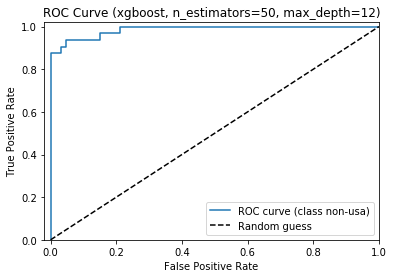

ROC_AUC: 0.9863
Optimal threshold: 0.4146
Accuracy: 0.9388


In [104]:
clf = xgb.XGBClassifier(max_depth=12, n_estimators=50, random_state=10)
clf.fit(X_train, y_train)

y_probas = clf.predict_proba(X_test) # predicted probabilities generated by sklearn classifier
plot_roc(y_test, y_probas[:,1], label="(xgboost, n_estimators=50, max_depth=12)")
print("ROC_AUC: {:.4f}".format(roc_auc_score(y_test, y_probas[:,1])))
print("Optimal threshold: {:.4f}".format(find_optimal_threshold(y_test, y_probas[:,1])))
print("Accuracy: {:.4f}".format(clf.score(X_test, y_test)))

# cross validation with ROC would provide further insights - now it depends on the train-test-split a lot
# https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc_crossval.html

Threshold: 0.41  | Accuracy : 0.95 - Precision: 0.91 - Recall(=TPR) : 0.94 - FPR : 0.05


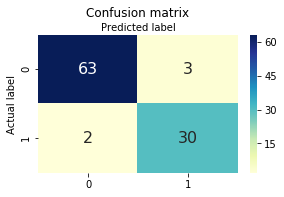

In [105]:
thr = 0.4146
prediction = (clf.predict_proba(X_test) >= thr)[:, 1]
print_metrics(y_test, prediction, thr)
plot_cnf_matrix(confusion_matrix(y_test, prediction))

# Variance of XGBoost

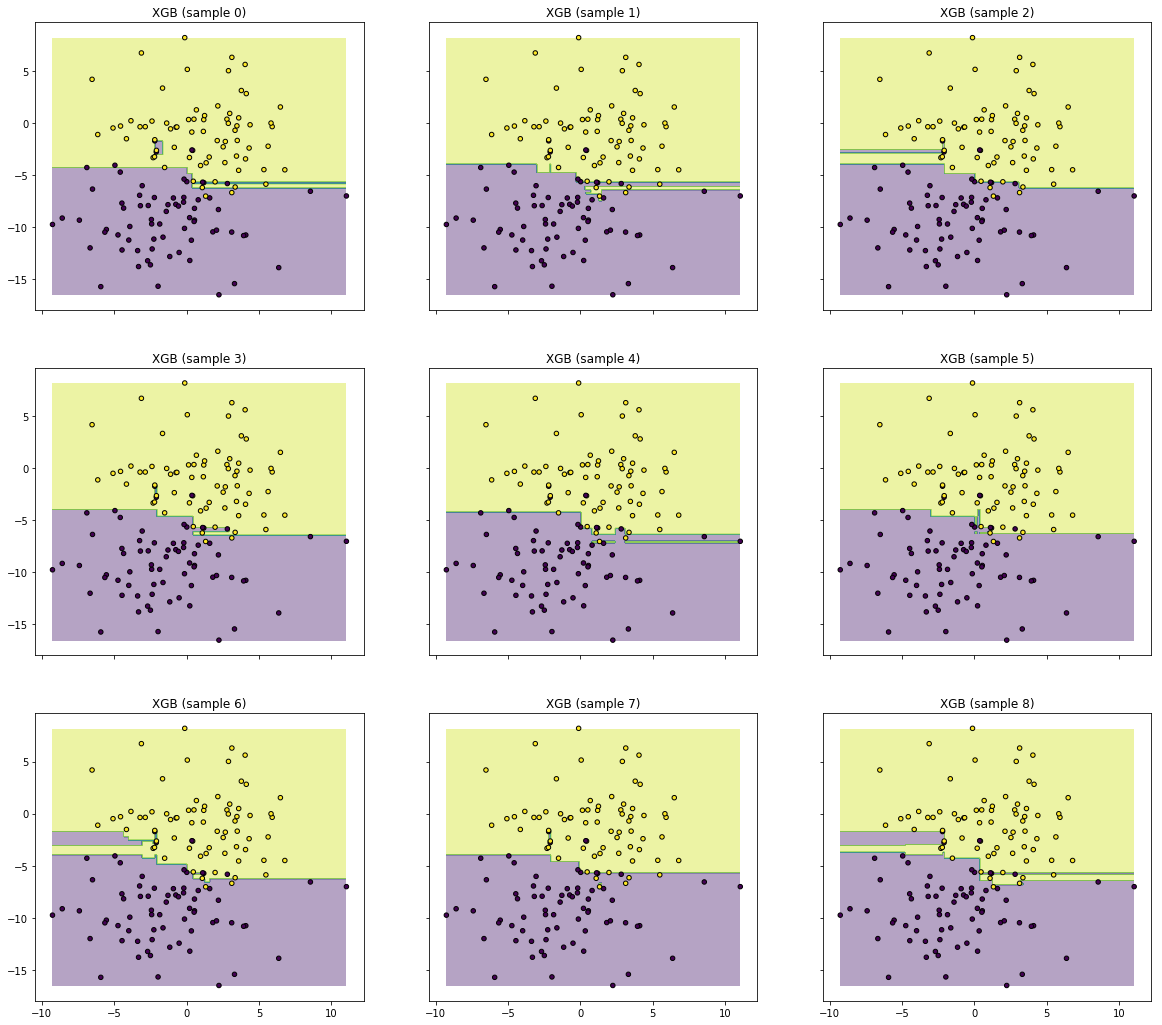

In [107]:
clf_arr = []  # this array holds the predictors
clf_name_arr = []  # this array holds the names of the predictors for visualization
X_arr = []

for i in range(n_samples):
    X = samples[i].iloc[:, [0,1]] 
    X_arr.append(X)
    y = samples[i]['y']
    clf = xgb.XGBClassifier(max_depth=max_tree_depth)
    clf.fit(X, y)
    clf_arr.append(clf)
    clf_name_arr.append("XGB (sample {})".format(i))
        
plot_decision_boundary(X_arr, clf_arr, clf_name_arr, xgboost=True)